In [13]:
from  scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd
import runner
import umm
from imp import reload
import numpy as np, statsmodels.stats.api as sms
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True


In [ ]:
reload(runner)
instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.9"
# instance_name="pfsp/rec19.txt"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug12.dat"
budgetGA=5
seed=2
budget=200
m_ini=10
budgetMM=10
# ratio_samples_learn=0.10
# weight_mass_learn=0.9
res = []
np.set_printoptions(linewidth=np.nan)
for ratio_samples_learn in [.1]:
  for weight_mass_learn in [0.9]:
    out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
    df = runner.run_once("uMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
                         ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename)
    res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
    print("best found",df.Fitness.min())
    #out_filename="local_new_CEGO"
    #runner.run_once("CEGO", instance_name, seed,budget = budget, m_ini = m_ini, budgetGA = budgetGA, out_filename = out_filename)

In [ ]:
# instance_name="pfsp/rec05.txt"
out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
df = pd.read_pickle(out_filename+'.pkl.gz')
#dfc, dfu = pd.read_pickle('local_new_CEGO.pkl.gz'),pd.read_pickle('local_new_uMM.pkl.gz');df = pd.concat([dfc, dfu]) 

print("instance name", df.instance.iloc[0], "- time", round(df.run_time.iloc[0], 2))
sns.set_style("whitegrid")
print(df.Fitness.min())
# 'pickles/pickLocal.pkl')#pick570618.pkl

color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(15,5))
    sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
    plt.show()

# Real data umm

we have executed umm with a grid of parameters ratio_samples_learn & weight_samples_learn. We load the min found in the execution in `df` and the best known solutions in `best`. (The best know for the real data LOP are give as a maximitaion problem so this value has to be corrected)



In [ ]:
find_in_lop_folder('N-be75eec', ret_value='path'),find_in_lop_folder('N-be75eec_150', ret_value='path')

In [ ]:
def find_in_lop_folder(instance_name, ret_value='instance'):
  import os
  for fol in os.listdir("lop"):
    if os.path.isdir("lop/"+fol):
      for file in os.listdir("lop/"+fol):
          if instance_name == file:
              path = "lop/"+fol+"/"+file
              with open(path) as f:
                n = int(f.readline().strip())
                instance = np.loadtxt(f, max_rows=n)
              if ret_value == 'instance' : return instance
              if ret_value == 'path': return path
  return None
#find_in_lop_folder('N-t1d100.01')

def get_best_know():
  best = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
## maximizar la de abajo o minimizar la de arriba, el plateamiento es distint, hay q ajustar los datos que nos dan del best_fval
  # cambia los de la carperta LOP 
  for instance_name in best.instance_name:
    inst = find_in_lop_folder(instance_name)
    if inst is not None:
      ins, be = inst.sum() , best[best.instance_name==instance_name].best_known_global.values[0] 
  #     print(ins, be)
      best.loc[best.instance_name==instance_name, 'best_known_global'] = ins - be 
  return best



## which ratio_samples_learn & weight_samples_learn is the best for each instance?

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

Overall, we can say that `ratio_samples_learn=0.1` and `weight_samples_learn=0.9` is a reasonable choice

N-atp111


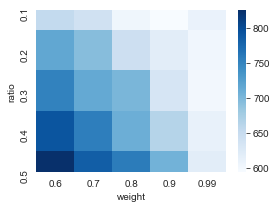

N-atp134


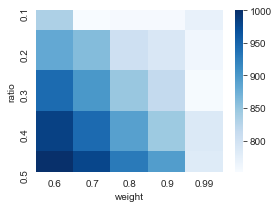

N-be75eec-150


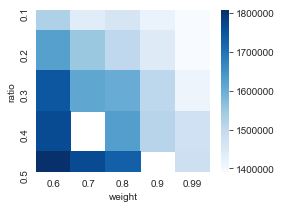

N-be75np-150


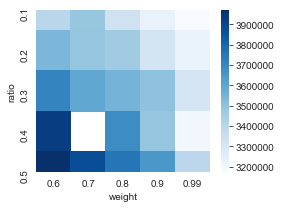

N-p50-01


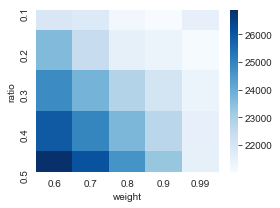

N-p50-02


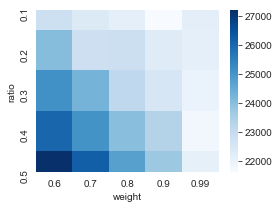

N-t1d100.01


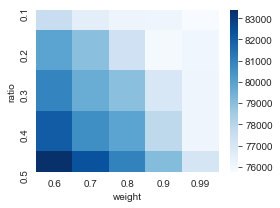

N-t1d100.02


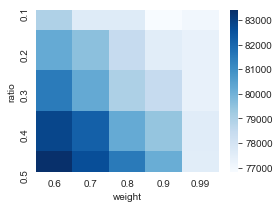

N-t1d150.01


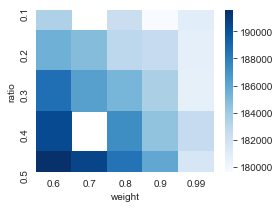

N-t1d150.02


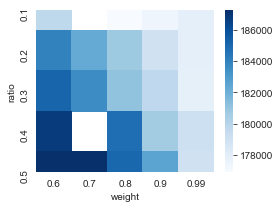

N-t2d150.01


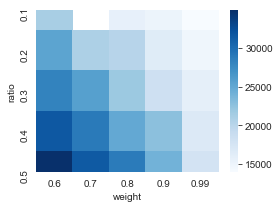

N-t2d150.02


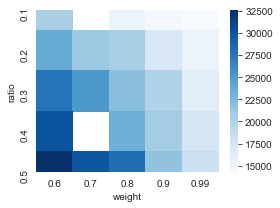

kra32.dat


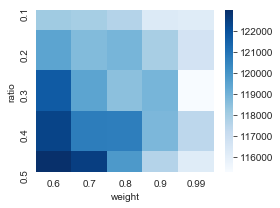

nug12.dat


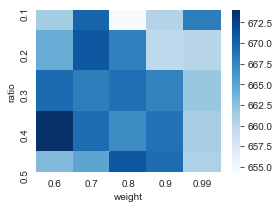

nug30.dat


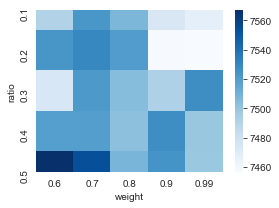

rec05


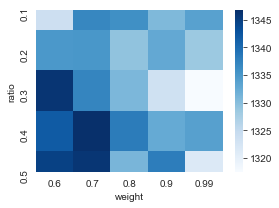

rec13


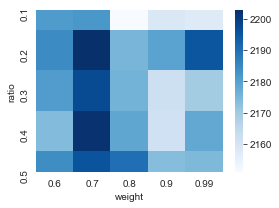

rec19


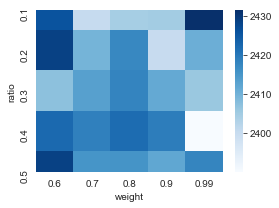

rec31


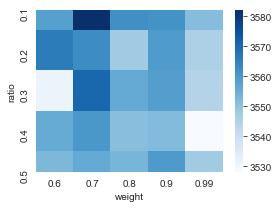

tho30.dat


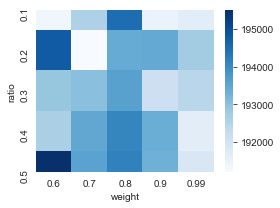

In [2]:
df = pd.read_csv('results/results.csv',index_col=0)
df.columns = [c if c!='min' else 'best' for c in df.columns]
df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df.columns = ['best_'+ c for c in df.columns]
dfres = df.reset_index()
dfres
for instance_name in dfres.filename.drop_duplicates().values:
  print(instance_name, )
  plt.figure(figsize=(4,3))
  sns.set_style("whitegrid")
  square = dfres[dfres.filename == instance_name].pivot_table(index='ratio', columns='weight', values='best_mean')
  sns.heatmap(square, cmap="Blues")
  plt.tight_layout()
  plt.savefig('img/heatmap_'+instance_name+'.pdf')

  plt.show()

# Compare CEGO and UMM
primrtoo QAP y PFSF, que hay de los dos y despues LOP, solo hay UMM

In [15]:

lis = []
for folder in ['results-loplib/', 'results/']  : 
  for filename in os.listdir(folder) :
    if 'pkl'in filename:
      lis.append(pd.read_pickle(folder+filename))
dfcego = pd.concat(lis)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl.gz'in filename])
dfumm['instance'] = dfumm['instance'].str[2:] #para quitar el punto barrra

Instance:  N-t1d100.01


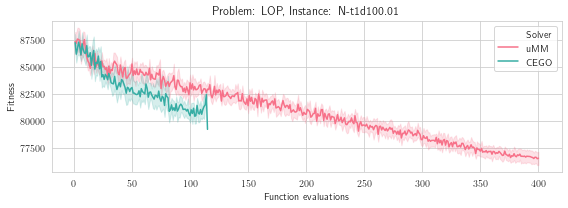

Instance:  N-t1d100.02


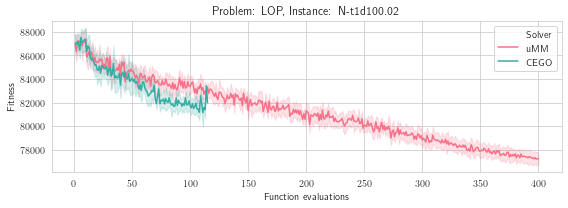

Instance:  N-t1d150.01


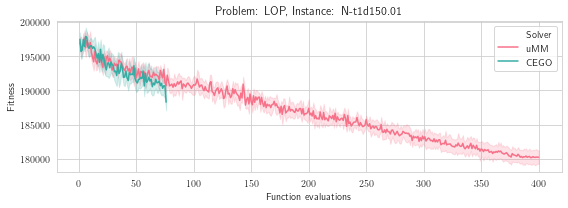

Instance:  N-t1d150.02


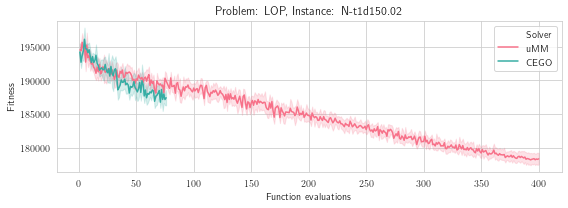

Instance:  N-t1d200.01


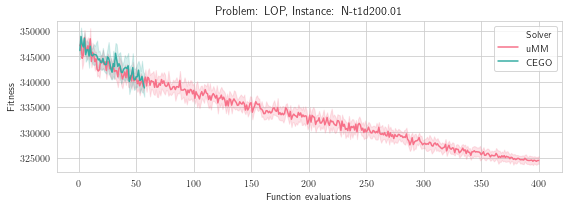

Instance:  N-t1d200.02


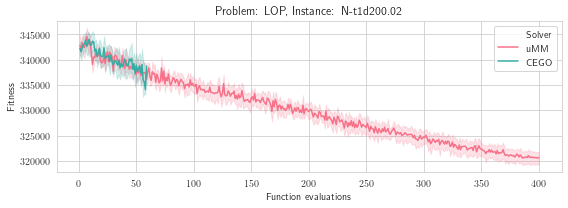

Instance:  N-t2d150.01


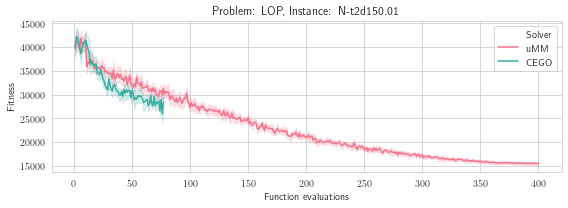

Instance:  N-t2d150.02


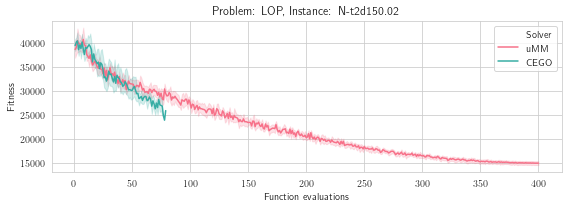

Instance:  N-t2d200.01


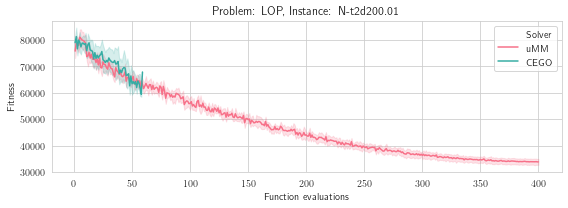

Instance:  N-t2d200.02


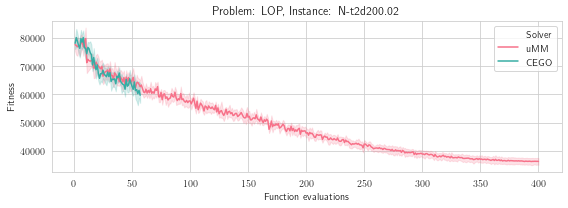

Instance:  N-p50-01


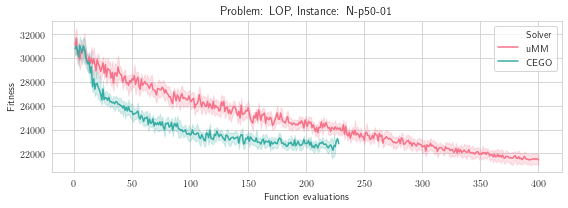

Instance:  N-p50-02


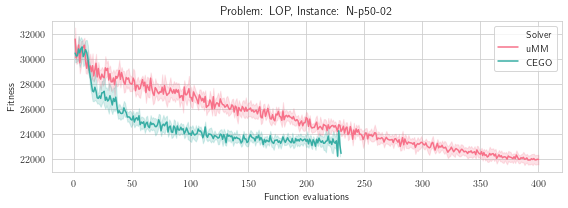

Instance:  N-be75eec_150


RuntimeError: latex was not able to process the following string:
b'Problem: LOP, Instance: N-be75eec_150'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/ekhi/.matplotlib/tex.cache/f930cc01bebe7440b01e5870eb1b7bb1.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file f930cc01bebe7440b01e5870eb1b7bb1.aux.
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ffamily Problem: LOP, Instance: N-be75eec_
                                                  150}
No pages of output.
Transcript written on f930cc01bebe7440b01e5870eb1b7bb1.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1235a3170> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'Problem: LOP, Instance: N-be75eec_150'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/ekhi/.matplotlib/tex.cache/f930cc01bebe7440b01e5870eb1b7bb1.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./f930cc01bebe7440b01e5870eb1b7bb1.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ffamily Problem: LOP, Instance: N-be75eec_
                                                  150}
No pages of output.
Transcript written on f930cc01bebe7440b01e5870eb1b7bb1.log.




RuntimeError: latex was not able to process the following string:
b'Problem: LOP, Instance: N-be75eec_150'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/ekhi/.matplotlib/tex.cache/f930cc01bebe7440b01e5870eb1b7bb1.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./f930cc01bebe7440b01e5870eb1b7bb1.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ffamily Problem: LOP, Instance: N-be75eec_
                                                  150}
No pages of output.
Transcript written on f930cc01bebe7440b01e5870eb1b7bb1.log.




<Figure size 576x216 with 1 Axes>

In [16]:
sns.set_style("whitegrid")
dfselected = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
dfselected
for inst in dfselected.instance_name.values:
  print("Instance: ",inst)
  df = pd.concat([dfumm[dfumm.instance.str.contains(inst)], dfcego[dfcego.instance.str.contains(inst)]],sort=False)
  if len(df)>0:
    plt.figure(figsize=(8,3))
    palette = sns.color_palette("husl", len(df['Solver'].drop_duplicates()))
    g = sns.lineplot(x='Function evaluations',y='Fitness',hue='Solver',data=df, palette=palette)
    g.set_title('Problem: '+df.Problem.iloc[0]+', Instance: '+ inst)
    plt.tight_layout()
    plt.savefig('img/fitness_real_'+df.instance.iloc[0].replace('/','_').replace('.','_')+'.pdf')
    plt.show()
#     print(kak)

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM '
 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


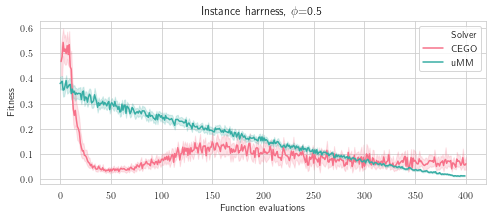

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM '
 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


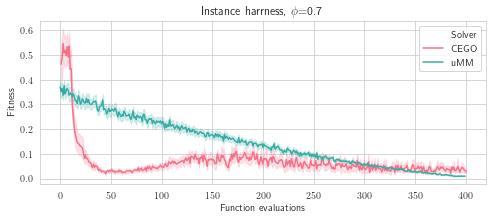

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'CEGO' 'uMM '
 'CEGO' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


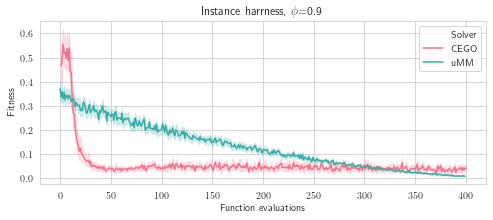

In [17]:
# COmpare in synthetic data
# Compare the convergence to lowest fitness funtion values by the two solvers
dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]
for phi in [0.5, 0.7, 0.9]: 
  df = pd.concat([dfcego[dfcego.instance.str.contains('phi='+str(phi))], dfumm[dfumm.phi_instance==phi]],sort=False)
  sns.set_style("whitegrid")
  print("ranking of the solvers by fitness")
  print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
  color_variable = 'Solver'
  y_variables = ['Fitness']#,'Distance','phi_sample'
  palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
  for y_variable in y_variables:
      plt.figure(figsize=(8,3))
      g = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
      g.set_title(r'Instance harrness, $\phi$='+str(phi))
      plt.savefig('img/fitness_phi_'+str(phi)+'.jpg')
      plt.show()


0    NaN
0    0.5
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.7
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.9
Name: phi_instance, dtype: float64 8000 4000 4000
ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'CEGO'
 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'uMM ']


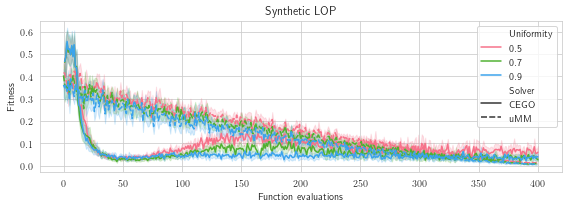

In [18]:

# COmpare in synthetic data in the same plot
# Compare the convergence to lowest fitness funtion values by the two solvers

dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]

lis = []
for phi in [0.5, 0.7, 0.9]: 
  a = dfcego[dfcego.instance.str.contains('phi='+str(phi))]
  b = dfumm[(dfumm.phi_instance==phi) & (dfumm.ratio_samples_learn==0.1503) & (dfumm.weight_mass_learn==0.8362)]
  df = pd.concat([a,b ],sort=False)
  df['Uniformity'] = phi
  print(df.phi_instance.drop_duplicates(), len(df), len(a), len(b))
  lis.append(df)
  
df = pd.concat(lis)

sns.set_style("whitegrid")
print("ranking of the solvers by fitness")
print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
color_variable = 'Uniformity'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(8,3))
    g = sns.lineplot(x='Function evaluations',y=y_variable,style='Solver', hue=color_variable,data=df, palette=palette)
    g.set_title('Synthetic LOP')
    plt.tight_layout()
    plt.savefig('img/synthetic_LOP_combined.pdf')
    plt.show()


Compare in the mean of min along each repetition
tiempos de ejec, intervalos de confianza



In [14]:
# tiempo medio y num medio de evaluaciones
a = dfcego.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
a['run_time'] = (a['run_time']/3600).round(1)
a.columns = ['Problem','instance','CEGO Runtime']
b = dfumm.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
b['run_time'] = (b['run_time']/3600).round(1)
b.columns = ['Problem','instance','UMM Runtime']
dftime = pd.merge(b,a)
a = dfcego.groupby(['Problem','instance','seed']).max()['Function evaluations'].groupby(['Problem','instance']).mean().reset_index()
a.columns = ['Problem','instance','CEGO F. evaluations']
dftime = pd.merge(dftime,a)
a = dfcego.groupby(['Problem','instance','seed']).Fitness.min()
b = dfumm.groupby(['Problem','instance','seed']).Fitness.min()
aa = a.groupby(['Problem','instance']).agg(Fitness_CEGO_mean='mean', Fitness_CEGO_std='std').reset_index() 
bb = b.groupby(['Problem','instance']).agg(Fitness_UMM_mean='mean', Fitness_UMM_std='std').reset_index() 
df = pd.merge(aa,bb)
aa = a.reset_index()
bb = b.reset_index()
for inst in df.instance:
  x,y = aa[aa.instance==inst].Fitness.values,bb[bb.instance==inst].Fitness.values
  cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
  df.loc[df.instance==inst,'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))
df['CEGO fitness'] = df.Fitness_CEGO_mean.round(1).astype(str)+" ("+df.Fitness_CEGO_std.round(1).astype(str)+")"
df['UMM fitness'] = df.Fitness_UMM_mean.round(1).astype(str)+" ("+df.Fitness_UMM_std.round(1).astype(str)+")"
df = df.drop(['Fitness_CEGO_mean'	,'Fitness_CEGO_std',	'Fitness_UMM_mean',	'Fitness_UMM_std'], axis=1)
df = pd.merge(df,dftime, on=['Problem', 'instance'])
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df = df[['Problem', 'Instance','UMM fitness', 'CEGO fitness',	'Confidence interval',	'UMM Runtime',	'CEGO Runtime',	'CEGO F. evaluations']]
df


,Problem,Instance,UMM fitness,CEGO fitness,Confidence interval,UMM Runtime,CEGO Runtime,CEGO F. evaluations
0,LOP,N-t1d100.01,76119.6 (915.4),78696.6 (811.4),"(1763.5, 3390.5)",3.2,72.5,111.8
1,LOP,N-t1d100.02,76827.7 (891.0),79686.5 (367.9),"(2194.5, 3523.1)",3.2,72.9,110.7
2,LOP,N-t1d150.01,179508.3 (1647.9),187605.5 (1906.9),"(6420.3, 9774.1)",6.5,72.7,73.9
3,LOP,N-t1d150.02,177592.8 (1196.2),184320.9 (973.5),"(5700.5, 7755.7)",6.5,73.2,74.1
4,LOP,N-t1d200.01,323513.6 (1371.2),335391.1 (2289.0),"(10076.1, 13678.9)",10.7,73.2,55.6
5,LOP,N-t1d200.02,319675.8 (2242.6),333149.5 (2497.2),"(11242.0, 15705.4)",10.6,73.7,56.5
6,LOP,N-t2d150.01,15297.7 (563.5),24682.7 (976.6),"(8622.2, 10147.8)",7.0,72.9,74.6
7,LOP,N-t2d150.02,14724.9 (667.5),24250.8 (1354.9),"(8495.1, 10556.7)",7.1,72.8,74.8
8,LOP,N-t2d200.01,33465.2 (2001.0),57098.6 (4452.8),"(20284.5, 26982.3)",11.2,73.3,56.3
9,LOP,N-t2d200.02,35901.8 (2077.5),54895.6 (4589.7),"(15539.1, 22448.5)",11.2,73.5,55.6


In [ ]:
print(df.to_latex(index=False))